In [1]:
import warnings 
warnings.simplefilter("ignore")

#importing librarys
import os 
import keras 
import numpy as np 
import tensorflow as tf 
import tensorflow_addons as tfa 
import matplotlib.pyplot as plt 

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Convolution2DTranspose,BatchNormalization,Conv2D,ReLU,LeakyReLU
from IPython import display
from os import listdir 
from pathlib import Path 
from PIL import Image

ImportError: DLL load failed while importing _multiarray_umath: The specified module could not be found.

In [2]:
# creating helper function 

def image_decode(file_path):
    image=tf.io.read_file(file_path)
    image=tf.image.decode_jpeg(image,channels=3)
    image=(tf.cast(image,tf.float32)/127.5)-1
    image=tf.reshape(image,[*IMAGE_SIZE,3])
    return image

def load_dataset(directory, labeled=True):
    dataset=tf.data.Dataset.list_files(directory+"/*.jpg")
    dataset=dataset.map(image_decode,num_parallel_calls=AUTOTUNE)
    return dataset

AUTOTUNE=tf.data.experimental.AUTOTUNE

In [3]:
IMG_PATH='gan-getting-started'

In [4]:
MONET_FILENAME=tf.io.gfile.glob(str(IMG_PATH+'/monet_jpg/*.jpg'))
PHOTO_FILENAME=tf.io.gfile.glob(str(IMG_PATH+'/photo_jpg/*.jpg'))

In [5]:
IMAGE_SIZE=[256,256]

#loading dataset
monet_ds=load_dataset("gan-getting-started/monet_jpg",labeled=True).batch(1)
photo_ds=load_dataset("gan-getting-started/photo_jpg",labeled=True).batch(1)


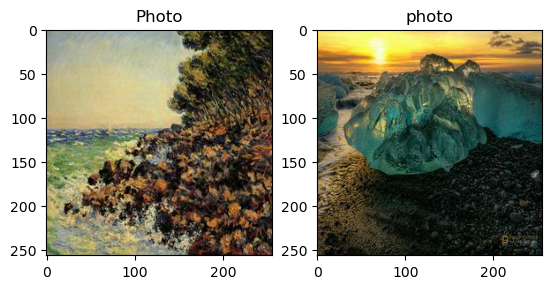

In [6]:
#visualizing those sample images 

example_monet=next(iter(monet_ds))
plt.subplot(121)
plt.title('Photo')
#technique used to normalize the pixel values of an image([-1,1] to [0,1])
plt.imshow(example_monet[0] * 0.5+0.5)

example_photo=next(iter(photo_ds))
plt.subplot(122)
plt.title("photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)


In [7]:
def down_sample(filters,size,apply_instancenorm=True):
    initializer=tf.random_normal_initializer(0.,0.02)
    gamma_init=keras.initializers.RandomNormal(mean=0.0,stddev=0.02)

    result=keras.Sequential()
    result.add(layers.Conv2D(filters,size,strides=2,padding='same',
                             kernel_initializer=initializer,use_bias=False))
    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
    result.add(layers.LeakyReLU())

    return result

In [8]:
'''The number of filters in the Conv2D layer
   and the size of the kernal are define '''

def downsample(filters, size, apply_instancenorm=True):
    #initializes the weight of the cnn kernal with a normal distrubution(mean=0.0,standard deviation = 0.02)
    initializer=tf.random_normal_initializer(0.,0.02)
    gamma_init=keras.initializers.RandomNormal(mean=0.0,stddev=0.02)

    #createan empty keras SequentialAC model 
    result=keras.Sequential()
    result.add(layers.Conv2D(filters,size,strides=2,padding='same',
                             kernel_initializer=initializer,use_bias=False))
    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
    result.add(layers.LeakyReLU())

    return result 

##spot the difference


In [9]:
def upsample(filters,size,apply_dropout=False):
    initializer=tf.random_normal_initializer(0.,0.02)
    gamma_init=keras.initializers.RandomNormal(mean=0.0,stddev=0.02)

    result=keras.Sequential()
    result.add(layers.Conv2DTranspose(filters,size,strides=2,padding='same',
                             kernel_initializer=initializer,use_bias=False))
    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
    
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    
    result.add(layers.ReLU())

    return result 

In [10]:
OUTPUT_CHANNELS=3

In [11]:
def generator():
    inputs=layers.Input(shape=[256,256,3])

    down_stack=[
        downsample(64,4,apply_instancenorm=False),
        downsample(128,4),
        downsample(256,4),
        downsample(512,4),
        downsample(512,4),
        downsample(512,4),
        downsample(512,4),
        downsample(512,4)
    ]

    up_stack=[
        upsample(512,4,apply_dropout=True),
        upsample(512,4,apply_dropout=True),
        upsample(512,4,apply_dropout=True),
        upsample(512,4),
        upsample(256,4),
        upsample(128,4),
        upsample(64,4)
    ]

    initialzer=tf.random_normal_initializer(0.,0.02)
    last=layers.Conv2DTranspose(OUTPUT_CHANNELS,4,
                                strides=2,
                                padding='same',
                                kernel_initializer=initialzer,
                                activation="tanh")
    
    x=inputs
    skips=[]
    for down in down_stack:
        x=down(x)
        skips.append(x)

    skips=reversed(skips[:-1])

    for up, skip in zip(up_stack,skips):
        x=up(x)
        x=layers.Concatenate()([x, skip])

    x=last(x)

    return keras.Model(inputs=inputs,outputs=x)

In [12]:
gen=generator()

In [13]:
def discriminator():
    initializer=tf.random_normal_initializer(0.,0.02)
    gamma_init=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.02)

    imp=layers.Input(shape=[256,256,3],name='input_image')

    x=imp

    down1=downsample(64,4,False)(x)
    down2=downsample(128,4)(down1)
    down3=downsample(256,4)(down2)

    zero_pad1=layers.ZeroPadding2D()(down3)
    conv=layers.Conv2D(512,4,strides=1,
                       kernel_initializer=initializer,
                       use_bias=False)(zero_pad1)
    
    norm1=tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu=layers.LeakyReLU()(norm1)
    zero_pad2=layers.ZeroPadding2D()(leaky_relu)

    last=layers.Conv2D(1,4,strides=1,
                       kernel_initializer=initializer)(zero_pad2)
    
    return tf.keras.Model(inputs=imp,outputs=last)


In [14]:
discc=discriminator()

In [15]:
strategy=tf.distribute.get_strategy()

In [16]:
with strategy.scope():
    monet_generator=generator()
    photo_generator=generator()

    monet_discriminator=discriminator()
    photo_discriminator=discriminator()

In [17]:
class CycleGen(keras.Model):
    def __init__(self, 
                 monet_generator,
                 photo_generator,
                 monet_discriminator,
                 photo_discriminator,
                 lambda_cycle=10):
        super(CycleGen,self).__init__()
        self.m_gen=monet_generator
        self.p_gen=photo_generator
        self.m_disc=monet_discriminator
        self.p_disc=photo_discriminator
        self.lambda_cycle=lambda_cycle

    def compile(
            self,
            m_gen_optimizer,
            p_gen_optimizer,
            m_disc_optimizer,
            p_disc_optimizer,
            gen_loss_fn,
            disc_loss_fn,
            cycle_loss_fn,
            identity_loss_fn
    ):
        super(CycleGen,self).compile()
        self.m_gen_optimizer=m_gen_optimizer
        self.p_gen_optimizer=p_gen_optimizer
        self.m_disc_optimizer=m_disc_optimizer
        self.p_disc_optimizer=p_disc_optimizer
        self.gen_loss_fn=gen_loss_fn
        self.disc_loss_fn=disc_loss_fn
        self.cycle_loss_fn=cycle_loss_fn
        self.identity_loss_fn=identity_loss_fn

    @tf.function
    def train_step(self, batch_data):
        real_monet,real_photo=batch_data

        with tf.GradientTape(persistent=True) as tape:
            #photo to monet and back to photo
            fake_monet=self.m_gen(real_photo,training=True)
            cycled_photo=self.p_gen(fake_monet,training=True)

            #monet to photo and back to monet 
            fake_photo=self.p_gen(real_monet,training=True)
            cycled_monet=self.m_gen(fake_photo,training=True)

            #generating itself 
            same_monet=self.m_gen(real_monet,training=True)
            same_photo=self.p_gen(fake_photo,training=True)

            #discriminator used to check ,inputting the real image 
            disc_real_monet=self.m_disc(real_monet,training=True)
            disc_real_photo=self.p_disc(real_photo,training=True)

            #discriminator used to check , inputting the fake image 
            disc_fake_monet=self.m_disc(fake_monet,training=True)
            disc_fake_photo=self.p_disc(fake_photo,training=True)

            #evaluate generator loss
            monet_gen_loss=self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss=self.gen_loss_fn(disc_fake_photo)

            #evaluate total cycle consistency loss 
            total_cycle_loss=self.cycle_loss_fn(real_monet,cycled_monet,self.lambda_cycle) + \
                             self.cycle_loss_fn(real_photo,cycled_photo,self.lambda_cycle)
            
            #evaluate total generator loss 
            total_monet_gen_loss=monet_gen_loss + total_cycle_loss + \
                                 self.identity_loss_fn(real_monet,cycled_monet,self.lambda_cycle)
            total_photo_gen_loss=photo_gen_loss + total_cycle_loss + \
                                 self.identity_loss_fn(real_photo,cycled_photo,self.lambda_cycle)
            
            #evaluate discriminator loss
            monet_disc_loss=self.disc_loss_fn(disc_real_monet,disc_fake_monet)
            photo_disc_loss=self.disc_loss_fn(disc_real_photo,disc_fake_photo)
        
        #calculate the gradient for generator and discriminator 
        monet_generator_gradients=tape.gradient(total_monet_gen_loss,self.m_gen.trainable_variables)
        photo_generator_gradients=tape.gradient(total_photo_gen_loss,self.p_gen.trainable_variables)

        monet_discriminator_gradients=tape.gradient(monet_disc_loss,self.m_disc.trainable_variables)
        photo_discriminator_gradients=tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)

        #apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients, self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients, self.p_gen.trainable_variables))
        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients, self.p_disc.trainable_variables))

        return{
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        } 
    def get_config(self):
        config = super(CycleGen,self).get_config()
        return config

    @tf.function
    def call(self,inputs):
        real_photo, real_monet=inputs

        fake_monet=self.m_gen(real_photo,training=False)
        cycled_photo=self.p_gen(fake_monet,training=False)

        fake_photo=self.p_gen(real_monet,training=False)
        cycle_monet=self.m_gen(fake_photo,training=False)

        return fake_monet,cycled_photo,fake_photo,cycle_monet

In [18]:
with strategy.scope():

    def discriminator_loss(real,generated):
        real_loss=tf.keras.losses.BinaryCrossentropy(from_logits=True,
                                                     reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real),real)
        generated_loss=tf.keras.losses.BinaryCrossentropy(from_logits=True,
                                                          reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated),generated)
        total_disc_loss=real_loss + generated_loss
        return total_disc_loss * 0.5

In [19]:
with strategy.scope():
    
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, 
                                    reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated),generated)

In [20]:
with strategy.scope():
    def calc_cycle_loss(real_image,cycled_image,LAMBDA):
        loss1=tf.reduce_mean(tf.abs(real_image-cycled_image))

        return LAMBDA * loss1

In [21]:
with strategy.scope():
    def identity_loss(real_image,same_image,LAMBDA):
        loss=tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

In [22]:
with strategy.scope():
    
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [23]:
with strategy.scope():
    cycle_gen_model=CycleGen(
        monet_generator,photo_generator,monet_discriminator,photo_discriminator
    )
    cycle_gen_model.compile(
        m_gen_optimizer=monet_generator_optimizer,
        p_gen_optimizer=photo_generator_optimizer,
        m_disc_optimizer=monet_discriminator_optimizer,
        p_disc_optimizer=photo_discriminator_optimizer,
        gen_loss_fn=generator_loss,
        disc_loss_fn=discriminator_loss,
        cycle_loss_fn=calc_cycle_loss,
        identity_loss_fn=identity_loss
    )

In [24]:
'''histroy=cycle_gen_model.fit(
    tf.data.Dataset.zip((monet_ds,photo_ds)),epochs=5
)'''

'histroy=cycle_gen_model.fit(\n    tf.data.Dataset.zip((monet_ds,photo_ds)),epochs=5\n)'

In [25]:
import random

In [26]:
def image_processing(img_path):
    img=tf.io.read_file(img_path)
    img=tf.image.decode_jpeg(img,channels=3)
    img=tf.image.resize(img,[256,256])
    img=(img / 127.5)-1
    img=tf.expand_dims(img,axis=0)

    return img 

In [38]:
def compare(photo_dir:str):
    "enter the directory of your photo"
    PHOTO_DIR=photo_dir
    PHOTO_FILENAME=os.listdir(PHOTO_DIR)

    rand_ind=random.randint(0,len(PHOTO_FILENAME) -1)
    img_path=os.path.join(PHOTO_DIR,PHOTO_FILENAME[rand_ind])

    img=image_processing(img_path)
    fake_monet,_,_,_=cycle_gen_model((img,img),training=False)
    prediction=fake_monet[0].numpy()
    prediction=(prediction * 127.5 + 127.5).astype(np.uint8)
    img=(img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    fig = plt.figure()
    fig.add_subplot(1, 2, 1)
    
    plt.title("Input Photos")
    plt.imshow(img)
    plt.axis("off") 
    fig.add_subplot(1, 2, 2)
    
    plt.title("Monet-esque Paintings")
    plt.imshow(prediction)
    plt.axis("off")

plt.show()



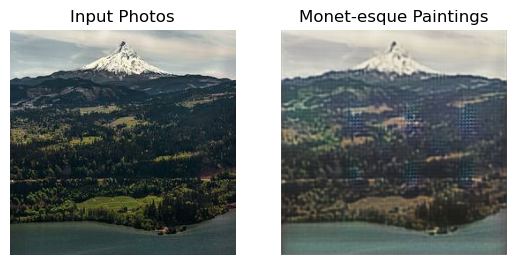

In [40]:
compare("gan-getting-started/photo_jpg")

In [29]:
'''cycle_gen_model.save('cycle-gen-models/model',save_format='tf')'''

"cycle_gen_model.save('cycle-gen-models/model',save_format='tf')"

In [30]:
'''cycle_gen_model.save_weights('cycle-gen-models/weights')'''

"cycle_gen_model.save_weights('cycle-gen-models/weights')"

In [ ]:
cycle_gen_model=tf.keras.models.load_model('cycle-gen-models/model')

In [ ]:
load_model=tf.keras.models.load_model('cycle-gen-models/model')

In [32]:
def lcompare(photo_dir:str):
    "enter the directory of your photo"
    PHOTO_DIR=photo_dir
    PHOTO_FILENAME=os.listdir(PHOTO_DIR)

    rand_ind=random.randint(0,len(PHOTO_FILENAME) -1)
    img_path=os.path.join(PHOTO_DIR,PHOTO_FILENAME[rand_ind])

    img=image_processing(img_path)
    fake_monet,_,_,_=load_model((img,img),training=False)
    prediction=fake_monet[0].numpy()
    prediction=(prediction * 127.5 + 127.5).astype(np.uint8)
    img=(img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    fig = plt.figure()
    fig.add_subplot(1, 2, 1)
    
    plt.title("Input Photos")
    plt.imshow(img)
    plt.axis("off") 
    fig.add_subplot(1, 2, 2)
    
    plt.title("Monet-esque Paintings")
    plt.imshow(prediction)
    plt.axis("off")

plt.show()

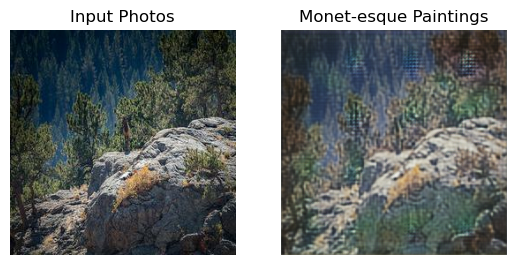

In [33]:
lcompare("gan-getting-started/photo_jpg")